# 案例分析
# 武汉 - 湖北（除武汉外） - 湖北以外 疫情对比

### 1. 载入数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm

%load_ext autoreload
%autoreload 2

In [4]:
%pdb off

Automatic pdb calling has been turned OFF


In [6]:
raw = utils.load_chinese_raw()

Last update:  2020-04-24 20:45:30
Data date range:  2020-01-22 to 2020-04-24
Number of rows in raw data:  150098


In [7]:
raw.head()

,continentName,continentEnglishName,countryName,countryEnglishName,province_name,provinceEnglishName,province_zipCode,province_confirmed,province_suspected,province_cured,province_dead,update_time,city_name,cityEnglishName,city_zipCode,city_confirmed,city_suspected,city_cured,city_dead,update_date
0,亚洲,Asia,中国,China,香港,Hong Kong,810000,1035,47.0,725,4,2020-04-24 20:45:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-24
1,北美洲,North America,美国,United States of America,美国,United States of America,971002,869172,0.0,80934,49963,2020-04-24 20:45:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-24
2,欧洲,Europe,英国,United Kingdom,英国,United Kingdom,961007,138078,0.0,344,18738,2020-04-24 20:45:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-24
3,欧洲,Europe,意大利,Italy,意大利,Italy,965008,189973,0.0,57576,25549,2020-04-24 20:45:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-24
4,欧洲,Europe,西班牙,Spain,西班牙,Spain,965015,219764,0.0,92355,22524,2020-04-24 20:45:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-04-24


In [5]:
data = utils.load_chinese_data()

Last update:  2020-04-24 20:45:30
Data date range:  2020-01-22 to 2020-04-24
Number of rows in raw data:  150098


ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [3]:
daily_frm = utils.aggDaily(data)

### 2. 把数据分成 武汉 -- 湖北（除武汉） -- 全国（除湖北） 三个区域各自整合

In [6]:
wuhan = daily_frm[daily_frm['city_name'] == '武汉'].groupby('update_date').agg('sum')
hubei_exWuhan = daily_frm[(daily_frm['province_name'] == '湖北省') & (daily_frm['city_name'] != '武汉')].groupby('update_date').agg('sum')
china_exHubei = daily_frm[daily_frm['province_name'] != '湖北省'].groupby('update_date').agg('sum')

contrast_frm = pd.merge(wuhan.add_suffix('_Wuhan'), hubei_exWuhan.add_suffix('_Hubei_exWuhan'), 'left', on='update_date')
contrast_frm = pd.merge(contrast_frm, china_exHubei.add_suffix('_China_exHubei'), 'left', on='update_date')

#### 画图比较确诊人数和死亡人数

KeyError: "None of [Index(['confirmed_Wuhan', 'confirmed_Hubei_exWuhan',\n       'confirmed_China_exHubei'],\n      dtype='object')] are in the [columns]"

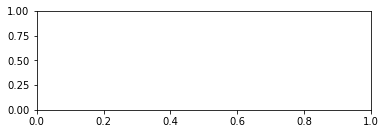

In [7]:
locations = ('Wuhan', 'Hubei_exWuhan', 'China_exHubei')
fig = plt.figure()
ax1 = fig.add_subplot(211)
contrast_frm.plot(y=['confirmed_' + suffix for suffix in locations], grid=True, figsize=(13, 8), style=['-*', '--*', ':*'], ax=ax1)
ax1.set_title('确诊人数对比', fontproperties=utils._FONT_PROP_, fontsize=15)
ax2 = fig.add_subplot(212)
contrast_frm.plot(y=['dead_' + suffix for suffix in locations], grid=True, figsize=(13, 8), style=['-*', '--*', ':*'], ax=ax2, sharex=True)
ax2.set_title('死亡人数对比', fontproperties=utils._FONT_PROP_, fontsize=15)
plt.show()

从上图可以看出，虽然武汉，湖北除武汉，全国除湖北三个区域的确诊人数接近，但是死亡人数却有极大的差异：

武汉 >> 湖北除武汉 >> 全国除湖北

这是为什么呢？

我们定义一个“简单死亡率” (Simple Death Rate)

$$简单死亡率(t) \equiv \frac{死亡人数(t)}{确诊人数(t)}$$

In [23]:
for loc in locations:
    contrast_frm['simpleDeathRate_' + loc] = contrast_frm['dead_' + loc] / contrast_frm['confirmed_' + loc]

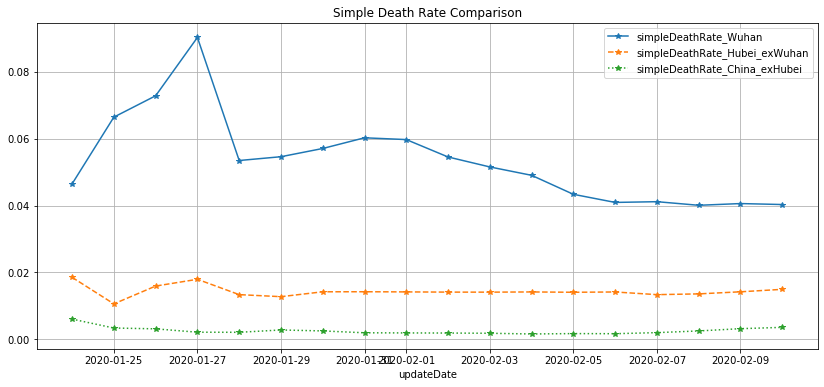

In [24]:
contrast_frm.plot(y=['simpleDeathRate_' + loc for loc in locations], grid=True, figsize=(14, 6), style=['-*', '--*', ':*'],
                 title='Simple Death Rate Comparison')

从上图可以看出，武汉死亡率 > 湖北（除武汉外）死亡率 > 全国其他地区死亡率

这说明武汉死亡人数高不是因为确诊人数多造成的。但是我们知道，死亡人数应该比确诊人数有个滞后，会不会是这个滞后造成计算不准确呢？

In [75]:
def lagDeathRate(df, location, lag):
    confirmed = df['confirmed_' + location][:-(lag+1)].to_numpy()
    if lag == 0:
        v = df['dailyNew_dead_' + location].to_numpy() / df['dailyNew_confirmed_' + location].to_numpy()
    else:
        v = df['dailyNew_dead_' + location][lag:].to_numpy() / df['dailyNew_confirmed_' + location][:-lag].to_numpy()
    return np.concatenate((np.array([np.nan] * (lag + 1)), v[1:]))

In [78]:
for lag in range(0, 14, 2):
    contrast_frm['lagDeath_' + str(lag) + '_Wuhan'] = lagDeathRate(contrast_frm, 'Wuhan', lag)
    contrast_frm['lagDeath_' + str(lag) + '_Hubei_exWuhan'] = lagDeathRate(contrast_frm, 'Hubei_exWuhan', lag)
    contrast_frm['lagDeath_' + str(lag) + '_China_exHubei'] = lagDeathRate(contrast_frm, 'China_exHubei', lag)

C:\Users\Jian\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jian\Anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


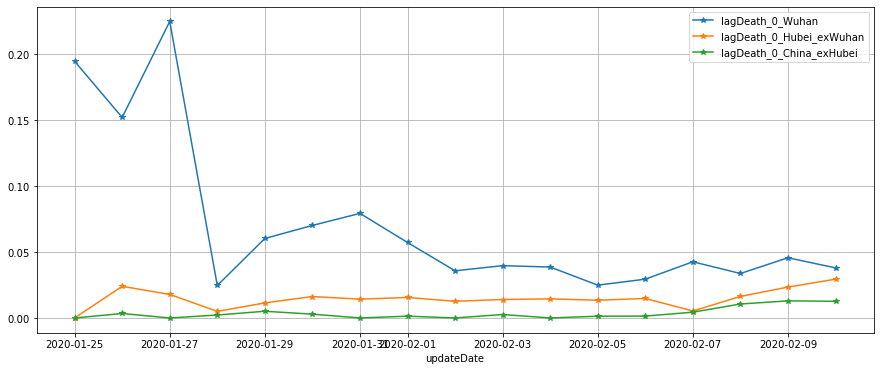

In [82]:
contrast_frm.plot(y=['lagDeath_0_Wuhan', 'lagDeath_0_Hubei_exWuhan', 'lagDeath_0_China_exHubei'], figsize=(15, 6), style='-*', grid=True)

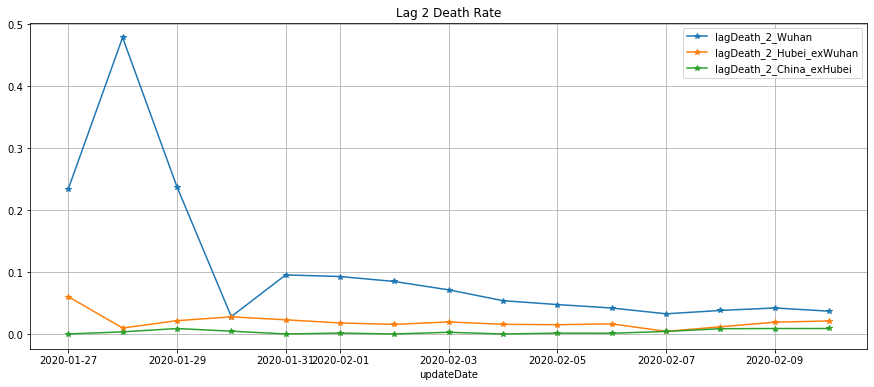

In [88]:
lag = 2
contrast_frm.plot(y=['lagDeath_' + str(lag) + '_Wuhan', 'lagDeath_' + str(lag) + '_Hubei_exWuhan', 'lagDeath_' + str(lag) + '_China_exHubei'], 
                  figsize=(15, 6), style='-*', grid=True, title='Lag ' + str(lag) + ' Death Rate')

In [84]:
contrast_frm.to_csv('death.csv', encoding='utf-8')

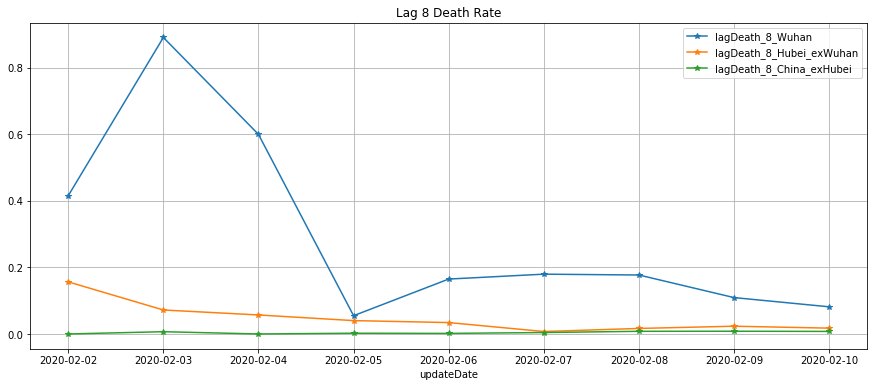

In [89]:
lag = 8
contrast_frm.plot(y=['lagDeath_' + str(lag) + '_Wuhan', 'lagDeath_' + str(lag) + '_Hubei_exWuhan', 'lagDeath_' + str(lag) + '_China_exHubei'], 
                  figsize=(15, 6), style='-*', grid=True, title='Lag ' + str(lag) + ' Death Rate')